In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.legacy.data as ttd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [3]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [4]:
df.columns = ['labels', 'data']

In [5]:
# Create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [6]:
df2 = df[['data', 'b_labels']]

In [7]:
TEXT = ttd.Field(sequential=True, batch_first=True, lower=False, pad_first=True)
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

In [8]:
dataset = ttd.TabularDataset(
    path='spam2.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

In [9]:
train_dataset, test_dataset = dataset.split()

In [10]:
TEXT.build_vocab(train_dataset,)

In [11]:
vocab = TEXT.vocab

In [13]:
device = torch.device('cuda:0')

In [14]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset),
    sort_key=lambda x: len(x.data),
    batch_sizes=(32, 256),
    device=device)

In [16]:
embed = nn.Embedding(len(vocab), 20).to(device)
for inputs, targets in train_iter:
    out = embed(inputs)
    print('Input shape:', inputs.shape, 'Output shape:', out.shape)
    break

Input shape: torch.Size([32, 56]) Output shape: torch.Size([32, 56, 20])


In [18]:
# DEFINE THE MODEL
class CNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_outputs):
        super(CNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.K = n_outputs
        
        self.embed = nn.Embedding(self.V, self.D)
        
        self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 128, 3, padding=1)
        
        self.fc = nn.Linear(128, self.K)
        
    def forward(self, X):
        out = self.embed(X)
        
        out = out.permute(0, 2, 1)
        out = self.conv1(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = F.relu(out)
        
        out = out.permute(0, 2, 1)
        out, _ = torch.max(out, 1)
        
        out = self.fc(out)
        return out

In [27]:
model = CNN(len(vocab), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(12604, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [28]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [29]:
def batch_grad(model, criterion, optimizer, train_iter, test_iter, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    for i in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_iter:
            targets = targets.view(-1, 1).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
            loss.backward()
            optimizer.step()
        
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in test_iter:
            targets = targets.view(-1, 1).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        
        train_losses[i] = train_loss
        test_losses[i] = test_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {i+1}/{epochs}, Train Loss: {train_loss:.4f},\t Test Loss: {test_loss:.4f}, Duration: {dt}')
        
    return train_losses, test_losses

In [30]:
train_losses, test_losses = batch_grad(model, criterion, optimizer, train_iter, test_iter, 10)

Epoch 1/10, Train Loss: 0.4003,	 Test Loss: 0.4684, Duration: 0:00:00.762002
Epoch 2/10, Train Loss: 0.2864,	 Test Loss: 0.2623, Duration: 0:00:00.744004
Epoch 3/10, Train Loss: 0.1608,	 Test Loss: 0.2709, Duration: 0:00:00.744013
Epoch 4/10, Train Loss: 0.1055,	 Test Loss: 0.3523, Duration: 0:00:00.749995
Epoch 5/10, Train Loss: 0.0688,	 Test Loss: 0.3606, Duration: 0:00:00.751010
Epoch 6/10, Train Loss: 0.0485,	 Test Loss: 0.2696, Duration: 0:00:00.766954
Epoch 7/10, Train Loss: 0.0336,	 Test Loss: 0.3043, Duration: 0:00:00.750962
Epoch 8/10, Train Loss: 0.0228,	 Test Loss: 0.3083, Duration: 0:00:00.745013
Epoch 9/10, Train Loss: 0.0144,	 Test Loss: 0.3421, Duration: 0:00:00.740014
Epoch 10/10, Train Loss: 0.0099,	 Test Loss: 0.3766, Duration: 0:00:00.787919


<function matplotlib.pyplot.legend(*args, **kwargs)>

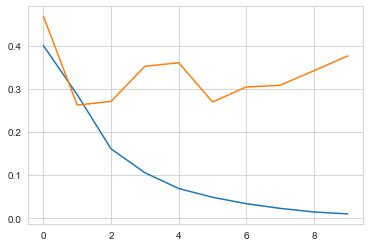

In [31]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend

In [32]:
n_correct = 0.
n_total= 0.
for inputs, targets in train_iter:
    targets = targets.view(-1, 1).float()
    
    outputs = model(inputs)
    predictions = (outputs  > 0)
    
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
train_acc = n_correct / n_total

n_correct = 0.
n_total= 0.
for inputs, targets in test_iter:
    targets = targets.view(-1, 1).float()
    
    outputs = model(inputs)
    predictions = (outputs  > 0)
    
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
test_acc = n_correct / n_total

print(f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Train Accuracy: 0.9985, Test Accuracy: 0.9474
